In [26]:
import pandas as pd
import random
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from collections import Counter
import matplotlib.pyplot as plt

import umap


In [2]:
def set_random_states(random_state):
    np.random.seed(random_state)
    os.environ['PYTHONHASHSEED'] = str(random_state)
    random.seed(random_state)

    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    return random_state

random_state = set_random_states(1618)

In [3]:
overall_df = pd.read_csv("./data/allIngredients.csv")
overall_df = overall_df.fillna(0)
overall_df = overall_df.sample(frac=1, random_state=random_state)
bread_cake_df = overall_df[overall_df['label'] != "banana"]
banana_df = overall_df[overall_df['label'] == "banana"]

In [4]:
X = bread_cake_df.drop("label", axis=1)
y = bread_cake_df["label"]


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state, stratify=y
)

In [6]:
knn_pipeline = Pipeline([
    ("l1norm", Normalizer(norm="l1")),  # convert each recipe to ingredient ratios
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

In [7]:
param_grid = {
    "knn__n_neighbors": [1, 3, 5, 7, 9, 11, 15, 21, 31],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["manhattan", "euclidean", "minkowski"],
    "knn__p": [1, 2],                # p=1 → L1, p=2 → L2 (only used if metric="minkowski")
    "knn__leaf_size": [10, 20, 30, 40, 50],
    "knn__algorithm": ["auto", "ball_tree", "kd_tree", "brute"]
}

In [8]:
grid = GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring="accuracy"
)

In [9]:
grid.fit(X_train, y_train)

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'knn__algorithm': ['auto', 'ball_tree', ...], 'knn__leaf_size': [10, 20, ...], 'knn__metric': ['manhattan', 'euclidean', ...], 'knn__n_neighbors': [1, 3, ...], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,norm,'l1'


In [10]:
print("Best Parameters:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

Best Parameters: {'knn__algorithm': 'auto', 'knn__leaf_size': 10, 'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'uniform'}
Best CV Score: 0.9739130434782609


In [11]:
y_pred = grid.predict(X_test)


In [12]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(f"Precision: {precision_score(y_test, y_pred, pos_label='bread')}")
print(f"Recall: {recall_score(y_test, y_pred, pos_label='bread')}")
print(f"F1-Score: {f1_score(y_test, y_pred, pos_label='bread')}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9333333333333333
Precision: 1.0
Recall: 0.9
F1-Score: 0.9473684210526315

Classification Report:
               precision    recall  f1-score   support

       bread       1.00      0.90      0.95        20
        cake       0.83      1.00      0.91        10

    accuracy                           0.93        30
   macro avg       0.92      0.95      0.93        30
weighted avg       0.94      0.93      0.93        30



In [13]:
X_banana = banana_df.drop("label", axis=1)
banana_predicted = grid.predict(X_banana)
print(Counter(banana_predicted))

Counter({'cake': 14, 'bread': 8})


In [21]:
umap_model = umap.UMAP(n_components=2, n_neighbors=10)
results = umap_model.fit_transform((overall_df[['flour','salt','yeast','oil','water','butter','egg','sugar','starter','milk','baking powder','bicarbonate of soda']].values))

/var/folders/12/p5c0vdcj3yx9xb69fcd0n3j80000gn/T/ipykernel_11728/4062716852.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))  # color map


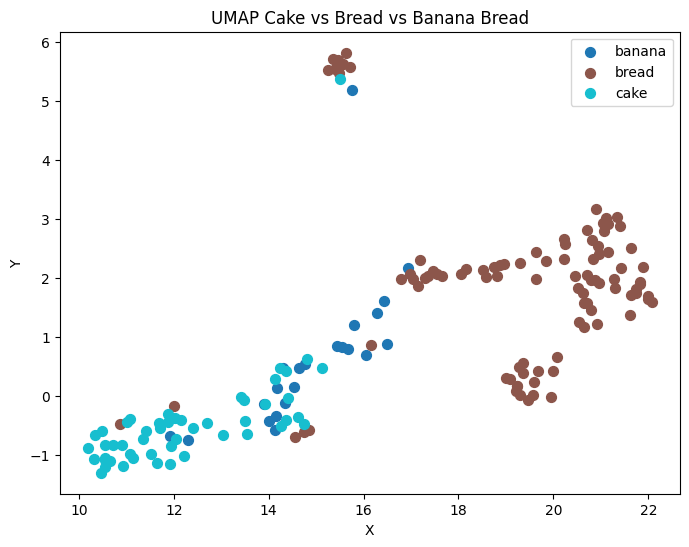

In [27]:
def plot_points(points, labels, title="UMAP Cake vs Bread vs Banana Bread", xlabel="X", ylabel="Y"):
    points = np.array(points)
    labels = np.array(labels)

    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))  # color map

    plt.figure(figsize=(8, 6))
    for i, label in enumerate(unique_labels):
        mask = labels == label
        plt.scatter(points[mask, 0], points[mask, 1], 
                    color=colors(i), label=str(label), s=50)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    # plt.grid(True)
    plt.savefig(f"./figures/umapIngredients.png", bbox_inches='tight', dpi=300)
    plt.show()

plot_points(results, list(overall_df['label']))